# MULTIPLE LINEAR REGRESSION TO PREDICT OP FOOTFALL

This model takes in various factors to predict Footfall of a clinical department in a tertiary hospital such as day of the week, the physicians available and the weather forecast for a day(high and low temp and percipitation parsed from accuweather page's html) as statistically significant factors. 

All the factors were assessed for statistical significance using ANOVA and pearson's coefficient

First all the libraries required for the analysis were loaded. Some of libraries are unused at present. These are for 
anticipated future testing and modelling.

## Importing libraries

In [118]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import urllib.request as ur
import time
import lxml.html as lh
header = {'User-Agent': 'Mozilla/5.0'}
import numpy as np # library to handle data in a vectorized manner
%matplotlib inline
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
# Import libraries
import requests
from bs4 import BeautifulSoup
import urllib.request as ur
import time
import lxml.html as lh
header = {'User-Agent': 'Mozilla/5.0'}
import folium # map rendering library
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

print('Libraries imported.')

Libraries imported.


In [119]:
#read and open URL to scrape
#url = 'http://accuweather.com/en/in/kozhikode/188806/september-weather/188806?year=2019&view=list'
#response = requests.get(url) #Connect to the URL
#print(response) #means it went through

In [120]:
#Parse HTML and save to BeautifulSoup object
#soup = BeautifulSoup(response.text, "html.parser")
#print(soup.prettify())

In [121]:
#since we cant parse html, i copy manually to a .txt and then edit to form a table.

### Weather data loaded in text file 
Formatting and cleaning the textual to table.

In [122]:
with open("weatherdata.txt") as file: # Use file to refer to the file object
    data = file.read()
# you probably want to use a space ' ' to replace `\n`
data = data.replace('\n', ' ').replace('\r', '')
data=data.replace('  ',',')
data=data.replace('° / ',',')
data=data.replace('° Actual Temp Precip,',',')
data=data.replace(' mm,,,',',')
data= data.replace('mm','')
data = data.replace(' ', '\n').replace('\r', '')
data
f=open('tablewet1.csv', 'r+')
f.write(data)
data
f.close()
data

'Thu,1,33,25,0,\nFri,2,34,27,4,\nSat,3,34,27,2,\nSun,4,32,27,0,\nMon,5,31,26,0,\nTue,6,29,24,83,\nWed,7,31,24,21,\nThu,8,28,24,97,\nFri,9,29,24,128,\nSat,10,26,23,130,\nSun,11,30,23,17,\nMon,12,30,24,12,\nTue,13,30,23,73,\nWed,14,28,24,30,\nThu,15,31,23,6,\nFri,16,29,25,11,\nSat,17,30,24,1,\nSun,18,30,24,0,\nMon,19,31,24,0,\nTue,20,31,25,0,\nWed,21,31,24,24,\nThu,22,30,24,18,\nFri,23,29,24,12,\nSat,24,30,24,14,\nSun,25,28,24,56,\nMon,26,30,24,34,\nTue,27,30,24,12,\nWed,28,32,24,27,\nThu,29,30,24,51,\nFri,30,31,23,6,\nSat,31,30,24,6\n'

In [123]:
headers=['Day','Date','hightemp', 'lowtemp', 'perci', 'extra'] #extra if any columns are there
dfw=pd.read_csv("tablewet1.csv", names=headers)
dfw.drop("extra", axis=1) #deleting extra column
dfw

,Day,Date,hightemp,lowtemp,perci,extra
0,Thu,1,33,25,0,NaN
1,Fri,2,34,27,4,NaN
2,Sat,3,34,27,2,NaN
3,Sun,4,32,27,0,NaN
4,Mon,5,31,26,0,NaN
5,Tue,6,29,24,83,NaN
6,Wed,7,31,24,21,NaN
7,Thu,8,28,24,97,NaN
8,Fri,9,29,24,128,NaN
9,Sat,10,26,23,130,NaN


### Loading the historical OP Data
Historical OP data is loaded and grouped by date


In [146]:
#reading cardiology data
dfc=pd.read_excel(r"C:\Users\admin\Downloads\Cardiology_data.xlsx",sheet_name='Visits')

In [125]:
dfc_dates = dfc.groupby(['Visit date'],as_index=False).count()
dfc_dates = dfc_dates.drop(['Patient code','Provider', 'Visit Type', "Referral type", 
                            "Referral Provider Code", "Referral Name"], 1)
dfc_dates.head()

,Visit date,Visit ID
0,2019-08-01,120
1,2019-08-02,101
2,2019-08-03,108
3,2019-08-04,2
4,2019-08-05,151


In [126]:
df=dfw.join(dfc_dates) #dff=final dataframe
#dropping unwanted columns date, visit date, and extra, not unsed in upcoming analysis

In [127]:
#dropping unwanted columns date, visit date, and extra, not unsed in upcoming analysis
df=df.drop(['extra','Visit date', 'Date'], axis =1)
#renaming VIsit ID to OPfootfall
df=df.rename(columns={"Visit ID":"OP"})

In [128]:
df.head(3)

,Day,hightemp,lowtemp,perci,OP
0,Thu,33,25,0,120
1,Fri,34,27,4,101
2,Sat,34,27,2,108


In [129]:
#deleting sunday from the analysis df
df=df[df.Day != 'Sun']
df.reset_index(drop=True, inplace=True)
df.head(26)

,Day,hightemp,lowtemp,perci,OP
0,Thu,33,25,0,120
1,Fri,34,27,4,101
2,Sat,34,27,2,108
3,Mon,31,26,0,151
4,Tue,29,24,83,118
5,Wed,31,24,21,97
6,Thu,28,24,97,77
7,Fri,29,24,128,45
8,Sat,26,23,130,25
9,Mon,30,24,12,84


### now we are ready for analysis

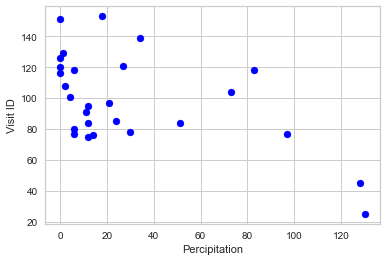

In [131]:
#first, for fun we can see scatter plot of percip and opfootfall
plt.scatter(df.perci, df.OP,color='blue')
plt.xlabel("Percipitation")
plt.ylabel("Visit ID")
plt.show()

Since the doctors and days of week are categorical data, dummies are assigned for these data

In [132]:
#One Hot encoding
for column in df.columns:
    if df[column].dtype==object:
        dummyCols=pd.get_dummies(df[column])
        df=df.join(dummyCols)
        del df[column]


In [133]:
df.head()

,hightemp,lowtemp,perci,OP,Fri,Mon,Sat,Thu,Tue,Wed
0,33,25,0,120,0,0,0,1,0,0
1,34,27,4,101,1,0,0,0,0,0
2,34,27,2,108,0,0,1,0,0,0
3,31,26,0,151,0,1,0,0,0,0
4,29,24,83,118,0,0,0,0,1,0


### Splitting data into a train and test set
To test the data for out of sample accuracy, we split the data into a train and test set.

In [149]:
#DO NOT RUN THIS CODE multiple times, this will randomize train and test sets
#remove # to run the code
#msk=np.random.rand(len(df))<0.8
#train =df[msk]
#test= df[~msk]


In [135]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
#saving train set to csv file
#train.to_csv("trainset.csv", index= None)
 #saving test set to csv file
#test.to_csv("testset.csv", index= None)


#Now we assign x and y vairables as arrays from train set to check fitness
x = np.asanyarray(train[['hightemp','lowtemp','perci', 'Fri', 'Mon', "Sat", 'Thu','Tue', "Wed"]])
y = np.asanyarray(train[['OP']])
regr.fit (x, y)
# to give the coeficient and intercept  coefficients outputs 
print ('Coefficients: ', regr.coef_)
print("intercept: ", regr.intercept_)

#Now we assign x and y vairables as arrays from test set to check fitness
y_hat_test= regr.predict(test[['hightemp','lowtemp','perci', 'Fri', 'Mon', "Sat", 'Thu','Tue', "Wed"]])
x1 = np.asanyarray(test[['hightemp','lowtemp','perci', 'Fri', 'Mon', "Sat", 'Thu','Tue', "Wed"]])
y1 = np.asanyarray(test[['OP']])

#Checking RMSE and Variance score for model evaluation
print("Residual sum of squares: %.2f"
      % np.mean((y_hat_test - y1) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x1, y1))

Coefficients:  [[  2.90130719   4.46274806  -0.31391173 -22.83355937  14.59281546
  -14.03025969  12.2028989   16.09915095  -6.03104625]]
intercept:  [-86.31002736]
Residual sum of squares: 70.50
Variance score: 0.87


In [139]:
y_hat_total = regr.predict(df[['hightemp','lowtemp','perci', 'Fri', 'Mon', "Sat", 'Thu','Tue', "Wed"]]).astype("int")

In [141]:
df['Predicted_Footfall']=y_hat_total

Lets rename the columns to correctly describe the data

In [142]:
df=df.rename(columns={"hightemp":"Highest_temperature", "lowtemp":"Highest_temperature", 
                      "perci":"Percipitation_mm","OP": "Actual_Footfall"})



In [143]:
df=df[['Highest_temperature','Highest_temperature','Percipitation_mm','Fri','Mon',"Sat",
       'Thu',"Tue","Wed","Actual_Footfall","Predicted_Footfall"]]
df.head(3)

,Highest_temperature,Highest_temperature,Highest_temperature,Highest_temperature,Percipitation_mm,Fri,Mon,Sat,Thu,Tue,Wed,Actual_Footfall,Predicted_Footfall
0,33,25,33,25,0,0,0,0,1,0,0,120,133
1,34,27,34,27,4,1,0,0,0,0,0,101,108
2,34,27,34,27,2,0,0,1,0,0,0,108,118


The Above table shows actual footfall for each day and predicted OP footfall for a day taking into consideration various 
factors given as input. The model achieves an 87% R-squared value on testing set and a standard error of 8 patients. 
### What this means to the model is that we are 95% (CI) sure that footfall would be +-8 patients the predicted value.

## Saving the model to a spreadsheet for convinience.

In [145]:
#saving data to file,
df.to_csv("Predictedmodel.csv", index=None)